In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [2]:
# 예측할 종목은 한양증권(001750) 입니다
# 기간은 00-01-04 ~ 21-02-05 입니다
# Yahoo Finanace에서 다운로드 받습니다 
# null값과 0값을 제거한 데이터를 사용합니다


df = pd.read_csv('C:\Jupyter_Project\Hanyang_Securities_63_21_21.csv')
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-09-03,8990,9010,8830,8840,8840,50420
1,2020-09-04,8770,8770,8620,8680,8680,50024
2,2020-09-07,8680,8860,8680,8740,8740,37808
3,2020-09-08,8840,8840,8700,8720,8720,27257
4,2020-09-09,8700,8700,8570,8600,8600,42491


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
100,2021-02-01,9200,9480,9100,9380,9380,81355
101,2021-02-02,9460,9810,9460,9700,9700,105755
102,2021-02-03,9850,10200,9800,9990,9990,170966
103,2021-02-04,10100,10200,9940,10150,10150,133504
104,2021-02-05,10200,10800,10150,10650,10650,251300


In [4]:
# OHLC를 Adj OHLC로 바꾸기 위한 비율입니다
# Adj OHLC는 과거의 절대가격을 현재 가격의 시점으로 보기위한 수정된 가격입니다
# 과거 발생한 액면분할과 현금배당을 반영한 Adj Close를 기준으로 조정합니다

ratio = df['Adj Close']/df['Close']
ratio

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
100    1.0
101    1.0
102    1.0
103    1.0
104    1.0
Length: 105, dtype: float64

In [5]:
df['Adj Open'] = df['Open']*ratio
df['Adj High'] = df['High']*ratio
df['Adj Low'] = df['Low']*ratio

In [6]:
df.drop(['Open','High','Low','Close'], axis=1, inplace=True)

In [7]:
df.rename(columns={'Adj Open':'Open', 'Adj High':'High', 'Adj Low':'Low', 'Adj Close':'Close'}, inplace=True)

In [8]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

df

,Open,High,Low,Close,Volume
0,8990.0,9010.0,8830.0,8840,50420
1,8770.0,8770.0,8620.0,8680,50024
2,8680.0,8860.0,8680.0,8740,37808
3,8840.0,8840.0,8700.0,8720,27257
4,8700.0,8700.0,8570.0,8600,42491
...,...,...,...,...,...
100,9200.0,9480.0,9100.0,9380,81355
101,9460.0,9810.0,9460.0,9700,105755
102,9850.0,10200.0,9800.0,9990,170966
103,10100.0,10200.0,9940.0,10150,133504


In [9]:
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

         Open      High       Low     Close    Volume
0    0.357447  0.303502  0.368421  0.278884  0.079970
1    0.263830  0.210117  0.267943  0.215139  0.079232
2    0.225532  0.245136  0.296651  0.239044  0.056462
3    0.293617  0.237354  0.306220  0.231076  0.036795
4    0.234043  0.182879  0.244019  0.183267  0.065191
..        ...       ...       ...       ...       ...
100  0.446809  0.486381  0.497608  0.494024  0.137632
101  0.557447  0.614786  0.669856  0.621514  0.183113
102  0.723404  0.766537  0.832536  0.737052  0.304665
103  0.829787  0.766537  0.899522  0.800797  0.234837
104  0.872340  1.000000  1.000000  1.000000  0.454405

[105 rows x 5 columns]


In [10]:
df= df_scaled

In [11]:
# Train과 Test를 분할합니다

from sklearn.model_selection import train_test_split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close',1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [13]:
x_train.shape, y_train.shape

((84, 4), (84,))

In [14]:
x_test.shape, y_test.shape

((21, 4), (21,))

In [15]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std
 
x_test -= mean
x_test /= std

In [16]:
from keras import models
from keras import layers
from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


def build_model():
    # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다
    # 마지막 레이어는 주택가격인 Y값 1개만 예측하면 되기 때문에 뉴런 수는 1개
    model = models.Sequential()
    model.add(layers.Dense(20, activation='relu',
                           input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(1))
    
    
    model.compile(optimizer='rmsprop', loss= RMSE, metrics=[soft_acc])
    return model

In [17]:
# k-겹 교차 검증 실시
# 현재 10겹이므로 한번 실행마다 50번 반복하고 결국 500번을 훈련하게 된다
# #0의 10개의 mae평균, #1의 10개의 mae평균,,,50번대의 10개의 mae평균,,,이렇게 500개의 mae를 구한다


k = 10
# len(train_data), 404
num_val_samples = len(x_train) // k # 101
num_epochs = 50
all_scores = []
all_RMSE_histories = []
all_RMSE_histories_t = []

for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
 
    # 훈련 데이터 준비: 다른 분할 전체
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)
 
    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # model.fit()함수로 회귀 모델을 학습시킨다
    history = model.fit(partial_x_train, partial_y_train,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=1)
    
    score = model.evaluate(x_test, y_test, batch_size=1)
    score_val = model.evaluate(val_data, val_targets, batch_size=1)
    
    
    RMSE_history = history.history['val_loss']
    all_RMSE_histories.append(RMSE_history)
    RMSE_history_t = history.history['loss']
    all_RMSE_histories_t.append(RMSE_history_t)
    
 
average_RMSE = [np.mean([x[i] for x in all_RMSE_histories]) for i in range(num_epochs)]
average_RMSE_t = [np.mean([x[i] for x in all_RMSE_histories_t]) for i in range(num_epochs)]

처리중인 폴드 # 0
Epoch 1/50
76/76 [==============================] - 4s 34ms/step - loss: 0.5625 - soft_acc: 0.5897 - val_loss: 0.0889 - val_soft_acc: 1.0000
Epoch 2/50
76/76 [==============================] - 0s 2ms/step - loss: 0.2345 - soft_acc: 0.5658 - val_loss: 0.0341 - val_soft_acc: 1.0000
Epoch 3/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0701 - soft_acc: 0.9152 - val_loss: 0.0426 - val_soft_acc: 1.0000
Epoch 4/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0593 - soft_acc: 0.9193 - val_loss: 0.0320 - val_soft_acc: 1.0000
Epoch 5/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0354 - soft_acc: 0.9378 - val_loss: 0.0549 - val_soft_acc: 1.0000
Epoch 6/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0408 - soft_acc: 0.9592 - val_loss: 0.0321 - val_soft_acc: 1.0000
Epoch 7/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0308 - soft_acc: 0.9778 - val_loss: 0.0391 - val_soft_acc: 1.0000
Epoch 8

Epoch 8/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0439 - soft_acc: 0.9536 - val_loss: 0.0329 - val_soft_acc: 1.0000
Epoch 9/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0455 - soft_acc: 0.9294 - val_loss: 0.0138 - val_soft_acc: 1.0000
Epoch 10/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0405 - soft_acc: 0.9545 - val_loss: 0.0126 - val_soft_acc: 1.0000
Epoch 11/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0349 - soft_acc: 0.9593 - val_loss: 0.0402 - val_soft_acc: 1.0000
Epoch 12/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0350 - soft_acc: 0.9526 - val_loss: 0.0223 - val_soft_acc: 1.0000
Epoch 13/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0416 - soft_acc: 0.9310 - val_loss: 0.0223 - val_soft_acc: 1.0000
Epoch 14/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0322 - soft_acc: 0.9600 - val_loss: 0.0220 - val_soft_acc: 1.0000
Epoch 15/50
76/

Epoch 15/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0407 - soft_acc: 0.9255 - val_loss: 0.0252 - val_soft_acc: 1.0000
Epoch 16/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0414 - soft_acc: 0.9149 - val_loss: 0.0292 - val_soft_acc: 1.0000
Epoch 17/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0321 - soft_acc: 0.9537 - val_loss: 0.0219 - val_soft_acc: 1.0000
Epoch 18/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0335 - soft_acc: 0.9230 - val_loss: 0.0228 - val_soft_acc: 1.0000
Epoch 19/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0356 - soft_acc: 0.9575 - val_loss: 0.0201 - val_soft_acc: 1.0000
Epoch 20/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0271 - soft_acc: 0.9591 - val_loss: 0.0201 - val_soft_acc: 1.0000
Epoch 21/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0257 - soft_acc: 0.9805 - val_loss: 0.0216 - val_soft_acc: 1.0000
Epoch 22/50
7

76/76 [==============================] - 0s 2ms/step - loss: 0.0262 - soft_acc: 0.9838 - val_loss: 0.0920 - val_soft_acc: 1.0000
Epoch 22/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0272 - soft_acc: 0.9644 - val_loss: 0.0978 - val_soft_acc: 1.0000
Epoch 23/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0267 - soft_acc: 0.9462 - val_loss: 0.0729 - val_soft_acc: 1.0000
Epoch 24/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0232 - soft_acc: 0.9866 - val_loss: 0.0798 - val_soft_acc: 1.0000
Epoch 25/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0263 - soft_acc: 0.9735 - val_loss: 0.0887 - val_soft_acc: 1.0000
Epoch 26/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0306 - soft_acc: 0.9211 - val_loss: 0.0823 - val_soft_acc: 1.0000
Epoch 27/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0282 - soft_acc: 0.9479 - val_loss: 0.0786 - val_soft_acc: 1.0000
Epoch 28/50
76/76 [======

Epoch 28/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0511 - soft_acc: 0.8989 - val_loss: 0.0458 - val_soft_acc: 1.0000
Epoch 29/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0318 - soft_acc: 0.8934 - val_loss: 0.0279 - val_soft_acc: 1.0000
Epoch 30/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0227 - soft_acc: 0.9637 - val_loss: 0.0399 - val_soft_acc: 1.0000
Epoch 31/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0672 - soft_acc: 0.9905 - val_loss: 0.0472 - val_soft_acc: 1.0000
Epoch 32/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0221 - soft_acc: 0.9887 - val_loss: 0.0310 - val_soft_acc: 1.0000
Epoch 33/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0285 - soft_acc: 0.9580 - val_loss: 0.0388 - val_soft_acc: 1.0000
Epoch 34/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0451 - soft_acc: 0.9415 - val_loss: 0.0469 - val_soft_acc: 1.0000
Epoch 35/50
7

Epoch 35/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0242 - soft_acc: 0.9936 - val_loss: 0.0291 - val_soft_acc: 0.7500
Epoch 36/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0253 - soft_acc: 0.9727 - val_loss: 0.0270 - val_soft_acc: 0.7500
Epoch 37/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0266 - soft_acc: 1.0000 - val_loss: 0.0271 - val_soft_acc: 0.7500
Epoch 38/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0291 - soft_acc: 0.9947 - val_loss: 0.0326 - val_soft_acc: 0.7500
Epoch 39/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0207 - soft_acc: 0.9947 - val_loss: 0.0304 - val_soft_acc: 0.7500
Epoch 40/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0236 - soft_acc: 0.9734 - val_loss: 0.0383 - val_soft_acc: 0.6250
Epoch 41/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0251 - soft_acc: 0.9947 - val_loss: 0.0195 - val_soft_acc: 0.8750
Epoch 42/50
7

Epoch 42/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0281 - soft_acc: 0.9942 - val_loss: 0.0633 - val_soft_acc: 1.0000
Epoch 43/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0211 - soft_acc: 0.9580 - val_loss: 0.0395 - val_soft_acc: 1.0000
Epoch 44/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0197 - soft_acc: 0.9529 - val_loss: 0.0706 - val_soft_acc: 1.0000
Epoch 45/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0226 - soft_acc: 0.9811 - val_loss: 0.0692 - val_soft_acc: 1.0000
Epoch 46/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0239 - soft_acc: 0.9573 - val_loss: 0.0478 - val_soft_acc: 1.0000
Epoch 47/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0239 - soft_acc: 0.9682 - val_loss: 0.0499 - val_soft_acc: 1.0000
Epoch 48/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0211 - soft_acc: 0.9612 - val_loss: 0.0576 - val_soft_acc: 1.0000
Epoch 49/50
7

Epoch 49/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0225 - soft_acc: 0.9596 - val_loss: 0.0382 - val_soft_acc: 0.8750
Epoch 50/50
8/8 [==============================] - 0s 1ms/step - loss: 0.0445 - soft_acc: 0.8750
처리중인 폴드 # 8
Epoch 1/50
76/76 [==============================] - 1s 5ms/step - loss: 0.2368 - soft_acc: 0.7463 - val_loss: 0.0336 - val_soft_acc: 1.0000
Epoch 2/50
76/76 [==============================] - 0s 2ms/step - loss: 0.1079 - soft_acc: 0.8842 - val_loss: 0.0289 - val_soft_acc: 1.0000
Epoch 3/50
76/76 [==============================] - 0s 2ms/step - loss: 0.1256 - soft_acc: 0.8642 - val_loss: 0.0305 - val_soft_acc: 1.0000
Epoch 4/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0803 - soft_acc: 0.8909 - val_loss: 0.0404 - val_soft_acc: 1.0000
Epoch 5/50
76/76 [==============================] - 0s 2ms/step - loss: 0.1147 - soft_acc: 0.8780 - val_loss: 0.0307 - val_soft_acc: 1.0000
Epoch 6/50
76/76 [==============================] 

76/76 [==============================] - 0s 2ms/step - loss: 0.0750 - soft_acc: 0.9652 - val_loss: 0.0752 - val_soft_acc: 0.5000
Epoch 5/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0857 - soft_acc: 0.9024 - val_loss: 0.0638 - val_soft_acc: 0.5000
Epoch 6/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0708 - soft_acc: 0.9104 - val_loss: 0.0551 - val_soft_acc: 0.7500
Epoch 7/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0798 - soft_acc: 0.9152 - val_loss: 0.0471 - val_soft_acc: 0.7500
Epoch 8/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0566 - soft_acc: 0.9785 - val_loss: 0.0454 - val_soft_acc: 0.8750
Epoch 9/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0695 - soft_acc: 0.9245 - val_loss: 0.0427 - val_soft_acc: 0.6250
Epoch 10/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0789 - soft_acc: 0.8617 - val_loss: 0.0394 - val_soft_acc: 0.7500
Epoch 11/50
76/76 [===========

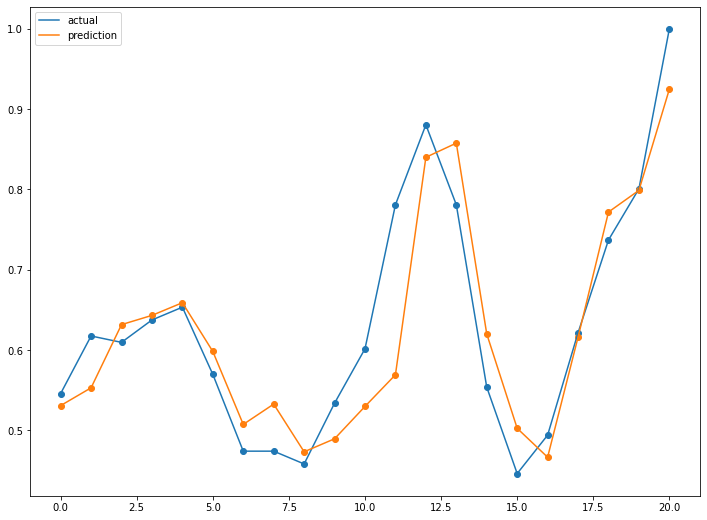

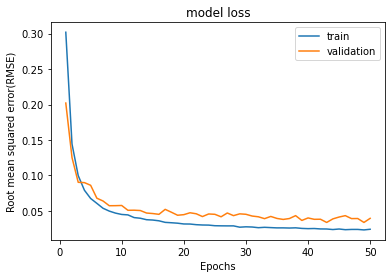

In [36]:
import matplotlib.pyplot as plt

pred = model.predict(x_test)
pred.shape

plt.figure(figsize=(12,9))
plt.plot(np.asarray(y_test), label='actual')
plt.plot(pred, label='prediction')
x_values = list(range(21))
plt.scatter(x_values, np.asarray(y_test))
plt.scatter(x_values, pred)
plt.legend()
plt.show()

plt.plot(range(1, len(average_RMSE_t) + 1), average_RMSE_t)
plt.plot(range(1, len(average_RMSE) + 1), average_RMSE)
plt.title('model loss')
plt.xlabel('Epochs')
plt.ylabel('Root mean squared error(RMSE)')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Text(0.5, 1.0, 'Prices vs Predicted price Index')

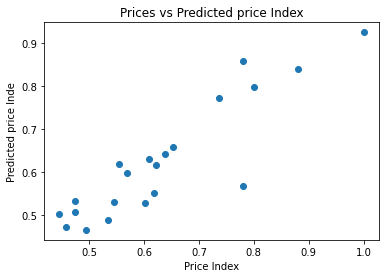

In [19]:
# 원래값과 예측 값이 일치하면 직선에 가깝게 분포가 된다

%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(np.asarray(y_test), pred)
plt.xlabel("Price Index")
plt.ylabel("Predicted price Inde")
plt.title("Prices vs Predicted price Index")

In [20]:
Y = np.asarray(y_test)
Y_hat = pred
RMSE = np.sqrt(np.mean((Y_hat-Y)**2))

print('[RMSE]')
print('train_loss = ' + str(score[0]))
print('valid_loss = ' + str(score_val[0]))
print("test_loss  =",RMSE)

[RMSE]
train_loss = 0.04576009884476662
valid_loss = 0.0157460980117321
test_loss  = 0.19754359374688388


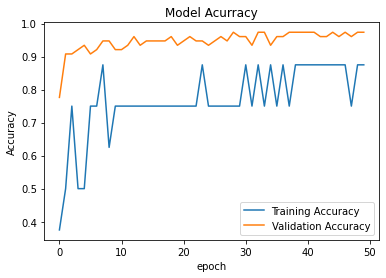

In [21]:
plt.plot(history.history['val_soft_acc'])
plt.plot(history.history['soft_acc'])
plt.title('Model Acurracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [35]:
pred

array([[0.53083867],
       [0.55298793],
       [0.6316612 ],
       [0.64316994],
       [0.6589396 ],
       [0.5982313 ],
       [0.5074221 ],
       [0.53271407],
       [0.47329122],
       [0.48950356],
       [0.5298095 ],
       [0.5692332 ],
       [0.8400236 ],
       [0.8576343 ],
       [0.62008184],
       [0.5025495 ],
       [0.4665661 ],
       [0.6160222 ],
       [0.77184224],
       [0.7988423 ],
       [0.92481947]], dtype=float32)

In [41]:
np.asarray(y_test)

array([0.54581673, 0.61752988, 0.60956175, 0.6374502 , 0.65338645,
       0.56972112, 0.47410359, 0.47410359, 0.45816733, 0.53386454,
       0.60159363, 0.78087649, 0.88047809, 0.78087649, 0.55378486,
       0.44621514, 0.4940239 , 0.62151394, 0.73705179, 0.80079681,
       1.        ])

In [42]:
y_test

84     0.545817
85     0.617530
86     0.609562
87     0.637450
88     0.653386
89     0.569721
90     0.474104
91     0.474104
92     0.458167
93     0.533865
94     0.601594
95     0.780876
96     0.880478
97     0.780876
98     0.553785
99     0.446215
100    0.494024
101    0.621514
102    0.737052
103    0.800797
104    1.000000
Name: Close, dtype: float64